# Working with Repeated Measures Data
---

## Learning Objectives
- Learn how to use split-apply-combine to average repeated measures data appropriately
- Learn how to properly visualize repeated measures data with Seaborn

---

## Introduction

In the previous chapter on Seaborn plots, we worked with some simulated reaction time (RT) data from 5 individual participants. We showed various Seaborn plots that allowed us to examine the variance in the data sets. However, for the sake of focusing on the different types of Seaborn plots and what they show us, we glossed over one really important aspect of the data — its *nesting structure*, and in particular the fact that we have repeated measures. Repeated measures data are very common in cognitive psychology and neuroscience. In fact, while they are often treated as a "special case" in statistical and data science texts, in this context we focus on them because most of the data we will encounter later in this course include repeated measures — and **it's very easy to treat the data incorrectly and draw incorrect conclusions if you're not used to working with repeated measures data**.

Recall that in the *Thinking About Data for Plotting* lesson, we learned that variance within individual units of measurement (such as individual participants) is not the same as the variance between participants. Furthermore, in a typical experiment our interest is in examining the average effects across individuals, and the range of differences between individuals. When we have nested data, such as many individual trials for each participant, this is because we recognize that any individual measurement may not be accurate, and so by averaging over many measurements we are likely to get a more accurate estimate of the true measurement for each individual. However, if we average the trial-to-trial variance of each individual (which is typically low, within the individual) across individuals, we lose the true inter-individual differences. 

For this reason, when plotting nested data it is usually appropriate to first average within each individual (for each condition), and then compute and visualize measures of the true inter-individual variability. Seaborn does not do this by default, and so the plots we generated in the previous lesson were actually inappropriate for assessing whether there was a true experimental effect. In this lesson we'll see how to use pandas `.groupby()` to use Seaborn appropriately with nested data. 

### About the data
First, let's load in a new data set (`flanker_rt_data.csv`). This is real data from a flanker experiment (similar to that described in the section on [spreadsheets](../2-nds/spreadsheets.html)).  In this experiment, participants had to press either the left or right arrow key, to indicate whether an arrow shown on the screen is pointing left or right, respectively. However, the catch is that the centre arrow is "flanked" by two other arrows on each side; these can be pointing the same way as the target arrow (congruent):

![flanker_congruent](images/flanker_congruent@0.75x.png)

or in the opposite direction (incongruent)

![flanker_incongruent](images/flanker_incongruent@0.75x.png)

We expect that the incongruent condition would be associated with slower RTs, because the flanking arrows create some visual confusion and response competition (cognitive interference; this process is not unlike that underlying the famous [Stroop](https://en.wikipedia.org/wiki/Stroop_effect) experiment, which you are likely familiar with). In order to confirm this hypothesis, we would want to get an estimate of the RT for each condition, from a representative sample of human participants. We need a number of participants because we know that there is variability in the average RT from person to person (**between-subject** variability). Here we have 27 participants.

To estimate the average RT for each condition for an individual, we would want to present many trials of each condition, in random order. We do this because there is always some trial-to-trial variability in measuring human RTs (**within-subject** variability). In this study each participant completed 40 trials in each condition. Thus we have repeated measures of RT for each participant, in each experimental condition. 

This experiment also had a third condition, *neutral*. On neutral trials, only the centre arrow was presented, without flankers. This condition was included to control for the fact that 5 arrows all pointing in the same direction might facilitate (speed up) responses relative to a single arrow — there might be additive, beneficial effects of congruent flankers. Comparing both the congruent and incongruent conditions to the neutral condition allows us to estimate the relative cost or benefit of flankers that are incongruent or congruent with the direction of the centre arrow. To ensure that there were as many neutral (single-arrow) as flanker (five-arrow) trials, 80 neutral trials were included per participant. 

So we have data from 27 participants, and approximately 160 trials per participant in total.  The nesting structure of this data set is thus trials (n=160) nested within conditions (n=3) nested within participants (n=27). 

## Load the data

First we'll import the packages we'll need, read in the data, and view a sample of 10 rows of the DataFrame:

~~~python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/flanker_rt_data.csv')

df.sample(10)
~~~

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the Data
df = pd.read_csv('data/flanker_rt_data.csv')

df.sample(10)


,participant,block,trial,flankers,rt
3951,s19,5,15,neutral,0.540786
745,s11,4,10,incongruent,0.421164
1658,s13,3,6,congruent,0.368926
4025,s5,2,25,incongruent,0.478156
294,s18,5,7,neutral,0.350264
2192,s9,5,6,congruent,0.413731
1814,s7,3,5,neutral,0.637700
1522,s1,3,30,congruent,0.597253
1436,s1,1,7,incongruent,0.405369
1323,s2,2,21,neutral,0.461946


## Examine the data without considering repeated measures

First we'll get some descriptive statistics for RT in each condition. We do this using pandas `.groupby()` method to group by flanker condition, and then we select the `rt` column for further processing by putting it in square brackets (which is pandas' way of selecting columns). Finally we chain all this with the `.describe()` method:

~~~python

df.groupby('flankers')['rt'].describe()
~~~

In [2]:
df.groupby('flankers')['rt'].describe()

,count,mean,std,min,25%,50%,75%,max
flankers,,,,,,,,
congruent,1076.0,0.470568,0.098868,0.009837,0.401727,0.449814,0.521514,0.953989
incongruent,1064.0,0.515996,0.107581,0.061839,0.449544,0.504629,0.573016,0.965726
neutral,2149.0,0.498310,0.098934,0.031539,0.433521,0.485642,0.552863,0.980535


Note the `count` (total number of data points), standard deviation (`std`) as well as the `min` and `max` values for each condition.

Let's look at a box plot of values in each condition:

~~~python

sns.catplot(kind='box',
           data=df,
           x='flankers', y='rt')
plt.show()
~~~

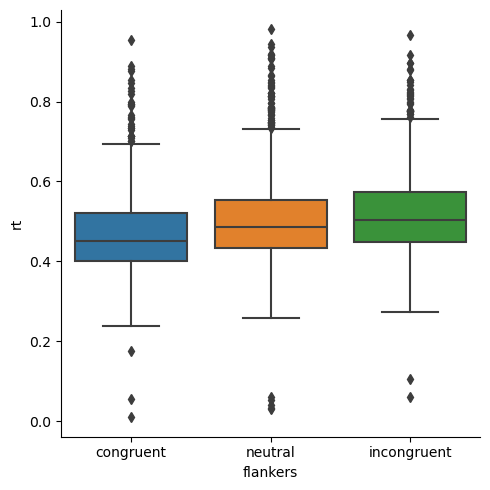

In [3]:
sns.catplot(kind='box',
            data=df,
            x='flankers', y='rt')

plt.show()

The data show the skew that is expected of RT data — there are fundamental human performance limits on how fast a person can respond (short RTs), but the upper limit of RTs is theoretically unlimited. In the present experiment, participants actually only had a 1 s window in which to respond, so the RTs are all less than 1. Nevertheless, the data are skewed because there is a wider range of RTs above the median than below. 

Another thing we can see about the distribution of values is that there are many outliers (individual points in the box plot) at the long end of the RT range, but few at the short end. This is, again, a consequence of the skewed nature of the data. However, notably some of the outliers on the short end of the distributions are suspicious: human RTs in very simple tasks (like pressing a button any time a light comes on) are rarely shorter than 200 ms, yet we have a few RT values below that. So our box plots suggest that we may have some anomalous data, perhaps from trials on which someone pressed a button accidentally prior to processing the actual direction of the arrow.

Finally, the box plots suggest that RTs are slowest in the incongruent condition and fastest in the congruent condition — consistent with our predictions based on past studies of the flanker effect. RTs for the neutral condition are in between the other two conditions. This suggests that perhaps both facilitation effects in the congruent condition, and interference effects in the incongruent condition, are present in the data. However, it's hard to know how large or believable those differences are, because the distributions overlap quite a bit between the three conditions.

### Stingray plot
Let's look at a couple of other ways of viewing the data that we learned about in the Seaborn lesson. First, we'll use a violin (stingray) plot to see both the KDE and box plot:

~~~python

sns.catplot(kind='violin',
           data=df,
           x='flankers', y='rt')
plt.show()
~~~

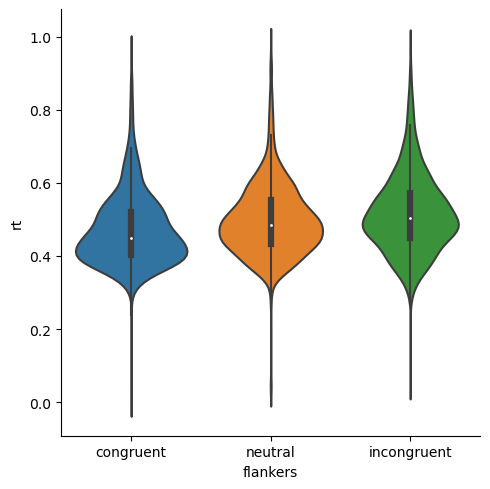

In [6]:
sns.catplot(kind='violin',
            data=df,
            x='flankers', y='rt')

plt.show()

The skewed nature of the data are again evident, but we can see that not only are the median values for the three conditions different, but the bulk of values in each distribution of RTs also appear to be rather different. That is, the "humps" in the middle of each distribution are relatively non-overlapping, although neutral and incongruent are fairly similar.

### Strip plot
Next let's look at a strip plot of the data, which plots each data point separately:

~~~python

sns.catplot(kind='strip',
           data=df,
           x='flankers', y='rt')
plt.show()
~~~

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


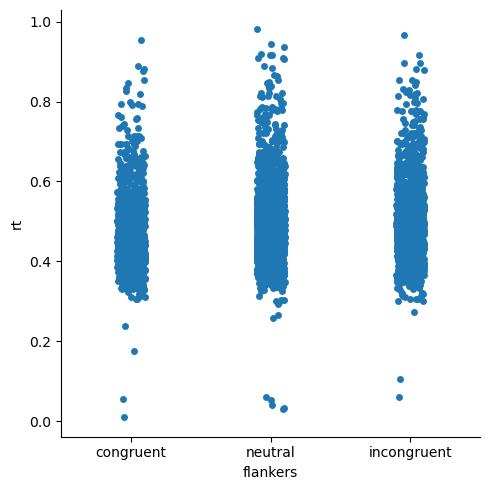

In [8]:
sns.catplot(kind='strip',
            data=df,
            x='flankers', y='rt')
plt.show()

This is really less informative than the above plots, because there are so many data points! Mostly we just see big patches of the plots for each condition with lots of individual values. 

However, the strip plots do show us something interesting that wasn't evident in the previous plots: the very fast outlier data points are quite anomalous, even compared to the very slow outliers. That is, there are few "fast" data points, and they are generally quite far from the rest of the distribution of RTs. In contrast, the slower data points are more plentiful, and seem to form a rather continuous set of values, albeit more sparse than the points closer to the centres of the distributions. This suggests that the slower data points might be quite believable as real data — mosly people make faster responses, but sometimes they're a bit slower. In contrast, the strip plot gives us greater confidence that the very fast RTs should be eliminated from analysis, because they are not just slightly-faster responses than the next-fastest responses.

### Point plot
Finally, let's look at a point plot. Recall that point plots show the mean for each condition, along with 95% confidence intervals (CIs) as the measure of variance. CIs are much narrower than the whiskers in box plots, because they are meant to represent our confidence in the estimate of the mean, rather than showing the overall distribution of values. In general, we can interpret conditions with non-overlapping 95% CIs as being "believably different" from each other, and likely to be statistically significantly different as well.

~~~python

sns.catplot(kind='point', join=False,
           data=df,
           x='flankers', y='rt', hue='flankers')
plt.show()
~~~

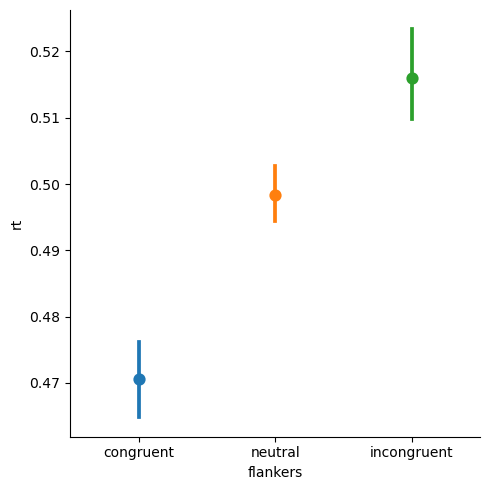

In [9]:
sns.catplot(kind='point', join=False,
            data=df,
            x='flankers', y='rt', hue='flankers')
plt.show()

~~~python

sns.set_context('talk')
sns.catplot(kind='box',
           data=df,
           x='flankers', y='rt', col='participant', col_wrap=6,
           )
plt.show()
sns.set_context('paper')
~~~

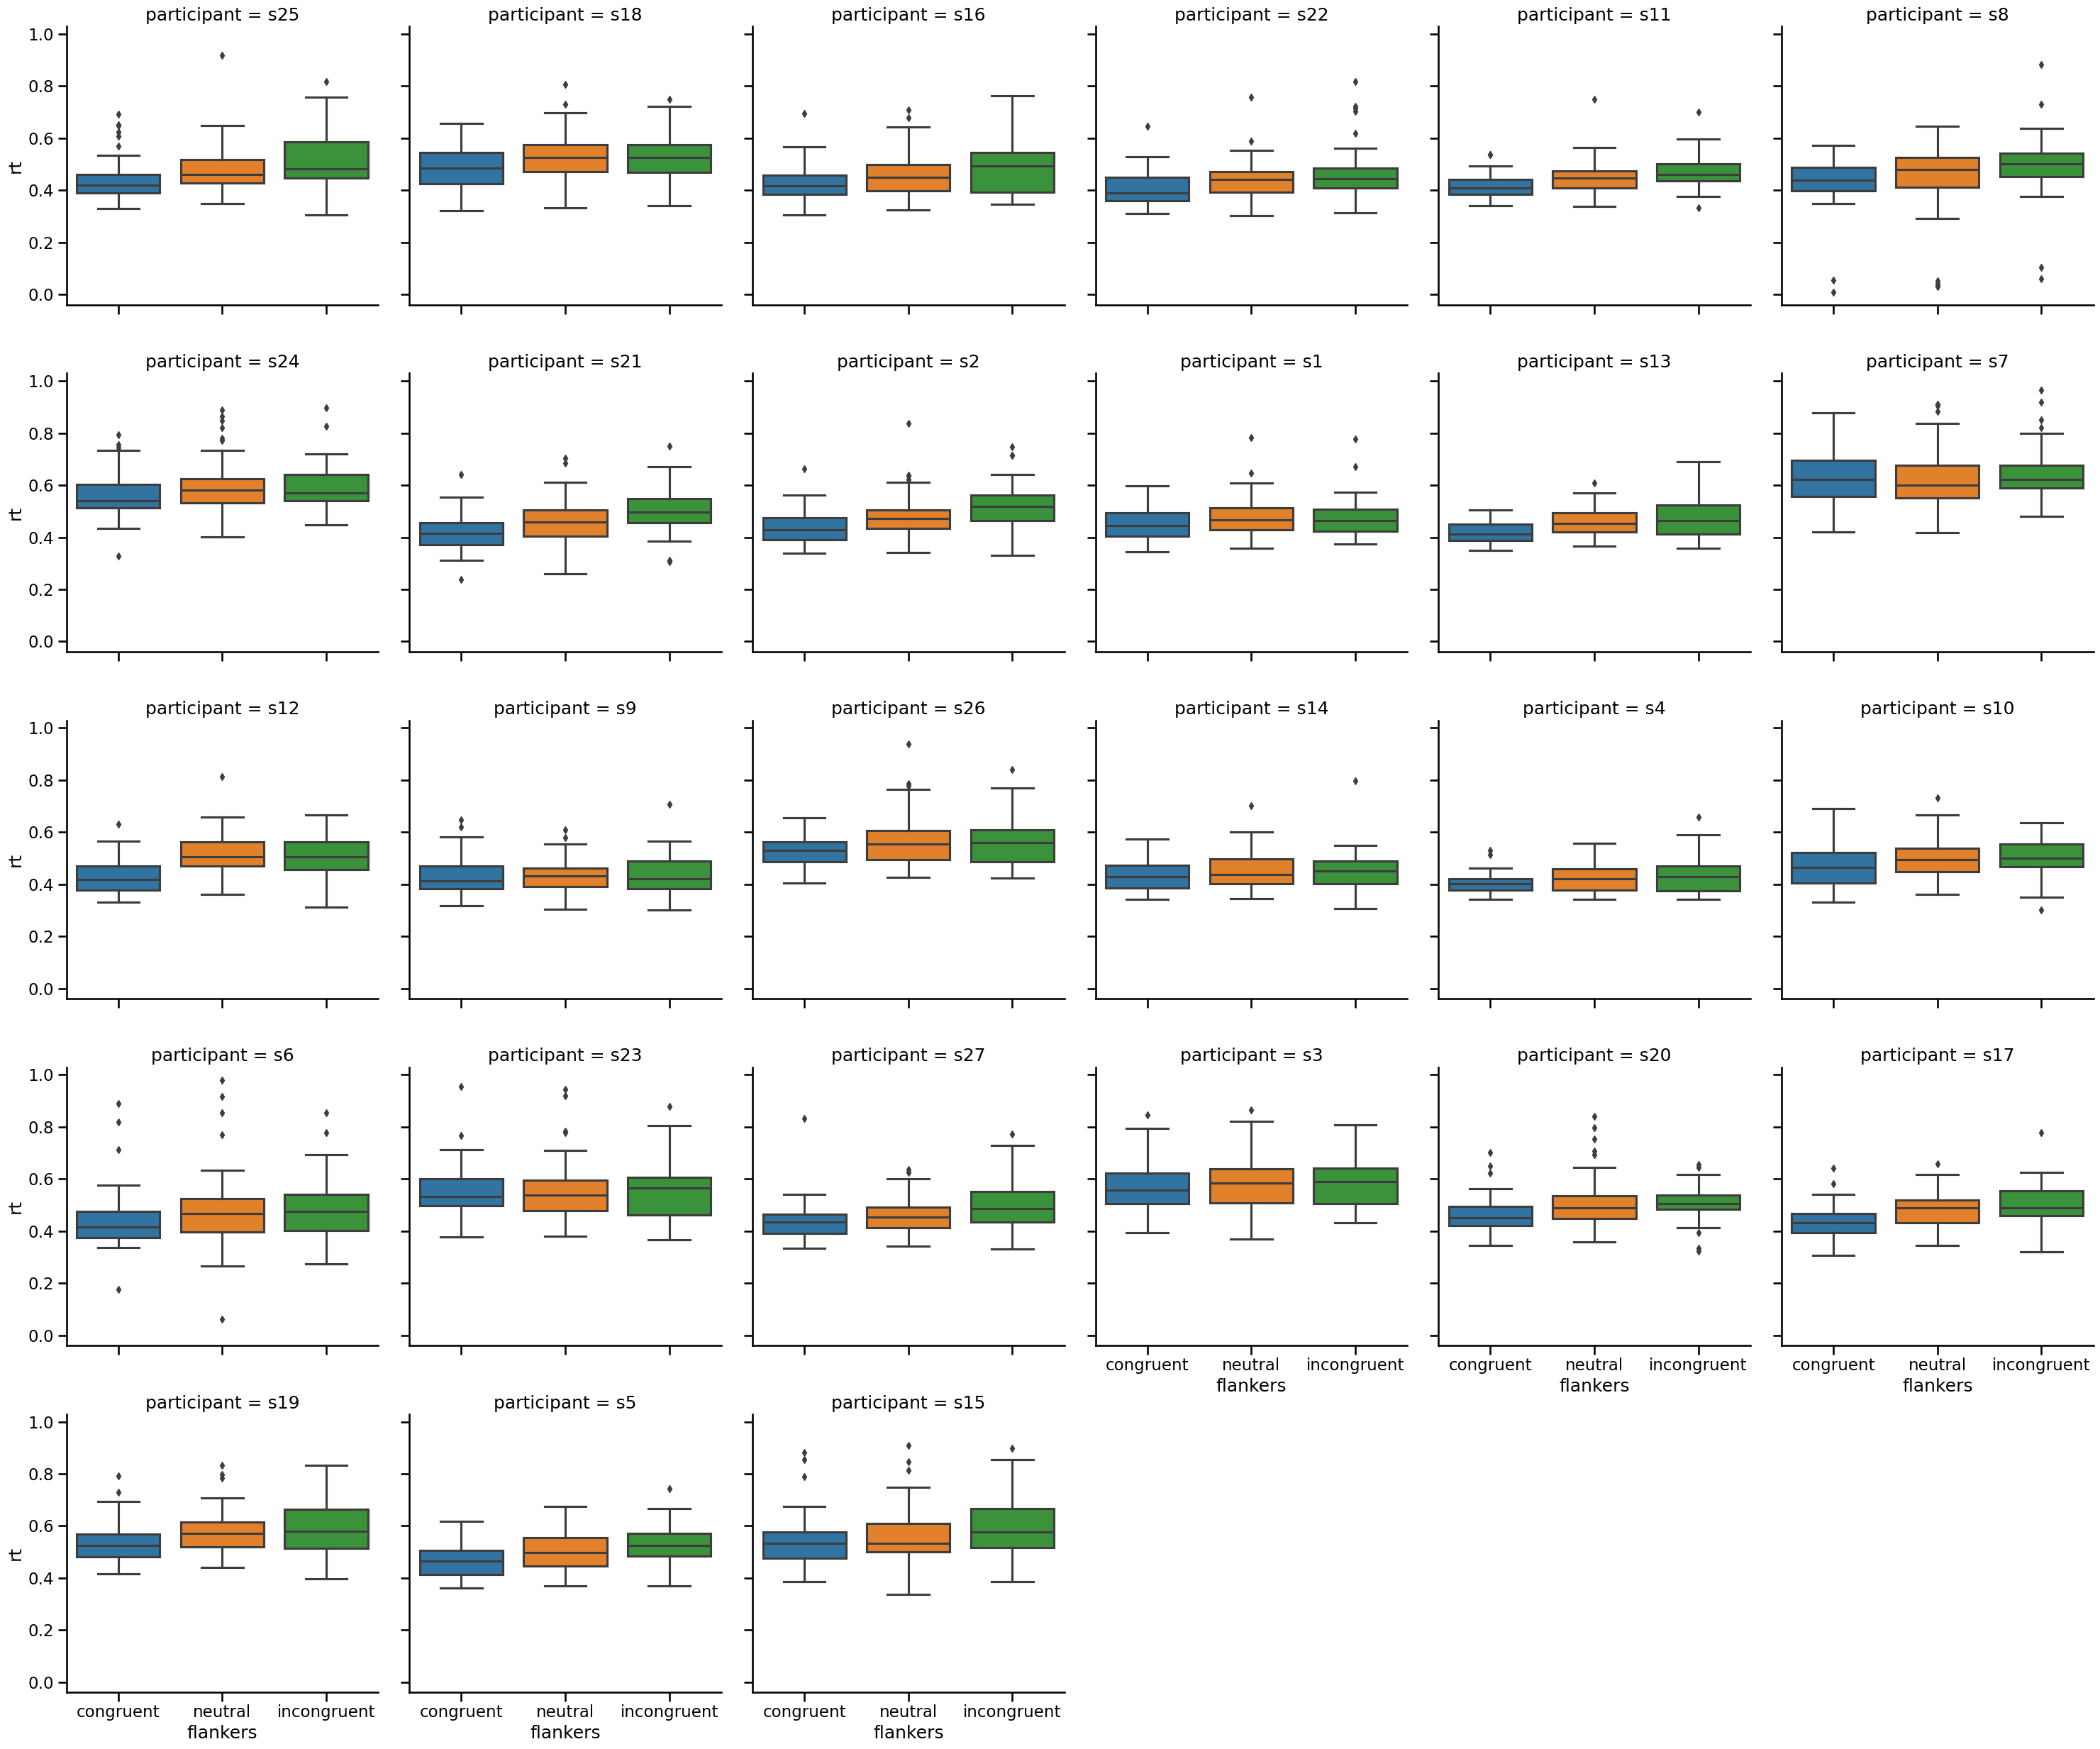

In [12]:
sns.set_context('talk')
sns.catplot(kind='box',
            data=df,
            x='flankers', y='rt', col='participant', col_wrap=6,
            )
plt.show()
sns.set_context('paper')

## Examine individual participant data
Now, let's use split-apply-combine to average the RTs within each individual participant (and within each condition within individuals) prior to the group-level descriptive statistics. We can do this in one line of code by chaining, combining the following steps:
- group by both participant ID and condition (split). Note that the argument to `.groupby()` is a list containing the two columns we want to group by
- compute the mean for each condition within each participant (apply)
- group by condition only (combining across participants)
- use `.describe()` to apply another computation (average across participants) and combine the output into a new table

~~~python

sns.catplot(kind='strip',
           data=df,
           x='flankers', y='rt', hue='participant')
plt.show()
~~~

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


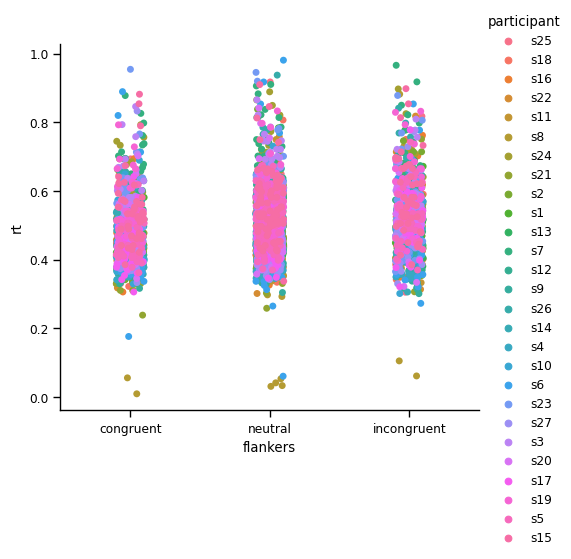

In [32]:
sns.catplot(kind='strip',
           data=df,
           x='flankers', y='rt', hue='participant')
plt.show()

This is a lot of numbers to look at! Indeed, so may that pandas doesn't show us all the rows. From what is shown, we can see that there is certainly variance in mean RTs for each individual, and in variance (as measured by standard deviation), but it's hard to get a real sense of how much variability there is, or whether there are any participants whose data may be anomalous relative to most others.

### Visualizing nested data with Seaborn

Seaborn makes it easy to separate data by participants in visualization. For example, we can generate box plots as we did above, but put participant on the *x* axis, and use the `hue` kwarg to colour-code flanker condition. Because there are lots of individual participants, we add the `aspect=3` kwarg to tell Seaborn to make the plot 3x as wide as it is tall.

~~~python

sns.catplot(kind='swarm',
           data=df,
           x='flankers', y='rt', hue='participant')
plt.show()
~~~

Another way to visualize so many different box plots is with Seaborn's `col` and `col_wrap` kwargs. On its own, `col=` will plot whatever variable you give it in separate columns — in our case, participants (rather than as different locations on the *x* axis, as shown above). Adding the `col_wrap` kwarg is necessary when the number of categories passed to `col` is large, as in our 27 participants. This kwarg tells Seaborn how many columns to put on one row before wrapping around to a new row. 

One last trick we will use is to set Seaborn's context to `talk`, to make the font size easier to read when we have so many plots. We'll set it back to `paper` after showing the plot, so our future plots aren't affected.

~~~python

sns.set_context('talk')
sns.catplot(kind='box',
           data=df,
           x='flankers', y='rt', col='participant', col_wrap=6,
           )
plt.show()
sns.set_context('paper')
~~~

This plot shows us that, indeed, there is variability among participants in both the median RTs and the variance (as indicated by the length of the whiskers, and the number and range of outlier points). Encouragingly, however, each individual seems to show the expected effect, of longer RTs for incongruent than congruent flankers. It also shows us that those anomalously fast RTs we saw above are contributed only by a couple of participants, again leading us to think that these are not believable data points.

Next we'll generate a strip plot, in which we colour-code the points according to which participant they are from:

~~~python

sns.catplot(kind='strip',
           data=df,
           x='flankers', y='rt', hue='participant')
plt.show()
~~~

This is not a lot more useful than the strip plot above, because Seaborn draws dots for each participant over those of previous participants. So we see lots of pink in the plot above, because that is the colour used for the last participant plotted. This is addressed by using a swarm plot (which will take a long time to execute if you try to run this, due to the large number of data points it's trying to plot):

~~~python

sns.catplot(kind='swarm',
           data=df,
           x='flankers', y='rt', hue='participant')
plt.show()
~~~

However, in this case there are so many data points that only a relatively small percentage of them are actually drawn (hence the warning messages above). It's hard to get a sense of the distributions of values for individual participants. 

## Appropriately dealing with repeated measures: Aggregating data by participants

Because there are so many data points, and variation in both the mean and range of values between participants, it is necessary to first average (**aggregate**) within each participant and condition, prior to computing descriptive statistics or visualizing. This ensures that the variance we are examining is the **between-subjects variance**, unconfounded with **within-subjects variance**. This is primarily important in generating plots that show confidence intervals (CIs), such as point plots and bar plots, for reasons explained below.

Seaborn has a way of doing this "on the fly" when you generate plots, using the `units=` kwarg and passing the name of the grouping variable for repeated measures (in this case, `participant`):

~~~python

sns.catplot(kind='point', join=False,
           data=df, units='participant',
           x='flankers', y='rt', hue='flankers')
plt.show()
~~~

**This is the most important figure in this lesson**. Compared to the point plot with 95% CIs that we generated above for the aggregated data, the CIs in this plot are much larger than those we saw earlier, in the point plot for the un-aggregated data. In that previous plot, the width of the CIs was only about 0.005 s (5 ms). Here, with the CIs computed properly (as reflecting the variance across individuals), the width of the CIs is approximately 0.02 s (20 ms). While still small relative to the differences in the means, the CIs are nonetheless roughly 4x wider in the aggregated data. 

### Why do CIs get larger when we properly aggregate repeated measures data?

We've already seen that the variance in the data actually went down, as quantified by the min-max range of values, and the standard deviation. So it may seem strange that the CIs do the opposite, and get bigger. To understand this, consider how the 95% CIs are computed:

$CI = 1.96 * \frac{std}{\sqrt n}$ 

CIs are computed by dividing the standard deviation ($std$) by the square root of $n$ — the number of data points used to compute the mean and standard deviation. In the un-aggregated data, this was approximately 1000 – 2000 data points for each condition. In contrast, for the aggregated data, $n$ = 27. Thus the CIs are much wider, because dividing by a larger number (1000 - 2000, rather than 27) results in a smaller number (even factoring in the differences in standard deviation, and the square root calculation). The values are multiplied by 1.96 because this is the *z* value corresponding to *p* = .05 in a normal distribution.

Notably, the conclusions that we would draw from this final plot would be quite different from if we had, in error, used the first point plot generated from the un-aggregated data. The first plot made it look like RTs in the three conditions were very different from each other, with little question as to the differences between them (due to the small and non-overlapping CIs). In contrast, when the data are properly aggregated as in the above plot, the CIs for neutral overlap a lot with both of the flanker conditions, which makes us less confident in their differences. 


Recall that the neutral condition was intended to help assess whether the congruent flankers showed facilitation relative to neutral, and whether incongruent flankers showed interference relative to neutral. The fact that the neutral condition overlaps with both others, but congruent and incongruent appear significantly different, suggests that the flanker effect (congruent faster than incongruent) may actually be due to a *combination* of facilitation and interference, rather than one or the other. 

The interpretation of the current data set is less important here than understanding the importance of recognizing and appropriately dealing with repeated-measures data. It is critical to understand the effects of repeated measures and nesting on estimate of variance — and of the differences between measures of variance in the data (as reflected by things like standard deviation, or box plots), and estimates of our confidence in the accuracy of the mean (CIs). CIs can be used for statistical inference (i.e., is there a believable difference?), whereas the variance reflected in box plots (and histograms, KDEs, etc.) is more informative at the early stages of exploring and understanding your data, and diagnosing potential issues in the data that might need to be addressed prior to inference about the true patterns in the data. Although this initial example used relatively "clean" data — and we didn't worry about doing anything to address the skew of the distributions or the outliers — in future lessons we will see cases where this first step can be critically important. 

## Aggregating using Split-Apply-Combine

While it's nice that Seaborn can aggregate repeated-measures data for us, that only works for generating Seaborn plots. It's also good to know how to create a DataFrame of aggregated data, which you can then use to generate tables of descriptive statistics, and eventually perform statistical tests on.

To do this, we will use *two* split-apply-combine operations in sequence. In one chained command, we will:
- split the data by participant and condition: `.groupby(['rt', 'flankers'])`
- select the `rt` column: `['rt']`
- apply a calculation to get mean RT for each participant/condition: `.mean()`
- split these results by condition only, to combine across participants: `.groupby('flankers')`
- apply descriptive statistics and combine the results in a table: `.describe()`

~~~python

df.groupby(['participant', 'flankers'])['rt'].mean().groupby('flankers').describe()
~~~

Compare the `count`, `std`, `min`, and `max` values here to that in our first descriptive statistics table above, which we'll reproduce here for ease of comparison:

~~~python

df.groupby('flankers')['rt'].describe()
~~~

You can see that the number of data points goes down from the total number of trials across all participants (~4200) to 27 per condition (the number of participants). The mean RTs do not actually change at all. This is expected because averaging is a linear operation, meaning that the average across all trials is the same as averaging first within participants then across trials. 

However, the range of values decreases when we look at the `min` and `max` values. This is a normal consequence of averaging — the most extreme values found in a set of individual data points will be reduced when we average by some grouping variables (like participant).  

The variance (as reflected by the standard deviation, `std`) gets smaller as well, for a similar reason: the variance is now among the average RTs for each participant in each condition, which have a smaller range than the raw data points. 

### Plot data aggregated across trials

Now let's re-plot the data using the same plots we did above, but now for the data averaged within participants. 

First let's save the aggregated data in a new DataFrame called `df_avg`. We chain the `.reset_index()` method to the end of this, because `.groupby()` sets the indexes of the DataFrame to be the grouping variables (in this case, `rt` and `flankers()`). This is ideal for looking at tables of the data (e.g., in the above, RT and condition are in bold), but index columns are not visible to Seaborn as data columns for plotting. So we use `.reset_index()` to convert `rt` and `flankers` back from indexes to regular DataFrame columns.

~~~python

df_avg = pd.DataFrame(df.groupby(['participant', 'flankers'])['rt'].mean()).reset_index()
~~~

Now let's generate a box plot of these data:

~~~python
sns.catplot(kind='box',
           data=df_avg,
           x='flankers', y='rt')
plt.show()
~~~

Another, somewhat confusing, thing is that the order of the conditions on the *x* axis is reversed: whereas before the order was congruent- neutral - incongruent, now neutral is last. This is a consequence of the `.reset_index()` method, which led to the conditions being re-ordered alphabetically. This highlights that its always good to pay close attention to your plot labels!

Seaborn actually has an easy way to specify the order of values on a categorical axis, if you want to: using the `order=` kwarg, and passing a list of conditions in the order you want them to appear:

~~~python

sns.catplot(kind='box',
           data=df_avg,
           x='flankers', y='rt',
           order=['congruent', 'neutral', 'incongruent'])
plt.show()
~~~

If you compare this to the box plot based on every data point that we generated earlier, you'll see that the range covered by the whiskers and the box are both smaller. This is consistent with the reduced range in the data that we observed in the tables of descriptive statistics. Likewise, the boxes (which represent the IQR) are now non-overlapping, whereas before they overlapped. 

### Strip plot
A strip plot of the data now much easier to make sense of, because we only have one point per participant in each condition:

~~~python

sns.catplot(kind='strip',
           data=df_avg,
           x='flankers', y='rt', hue='participant')
plt.show()
~~~

### Line plot
This makes it easier to get a sense of the variability between individuals. However, It's a bit hard to see how each individual's RT changes between the two experimental conditions. To facilitate this, let's use a point plot, which by default draws lines to join data from each individual:

~~~python

sns.catplot(kind='point',
           data=df_avg,
           x='flankers', y='rt', hue='participant',
           order=['congruent', 'neutral', 'incongruent'])
plt.show()
~~~

You may recall that point plots typically show means and 95% CIs, but the plot above lacks CIs. This is because in the `df_avg` DataFrame, there is only one value for each participant in each condition (because we averaged across trials). If we wanted to see CIs for each individual, we could use the un-aggregated data (`df`).

~~~python

sns.catplot(kind='point',
           data=df,
           x='flankers', y='rt', hue='participant',
           order=['congruent', 'neutral', 'incongruent'])
plt.show()
~~~

In [ ]:
sns.ca

## Point plots aggregated across participants

The CIs in the above plot don't, however, help us to make a simple inference as to whether, across all participants, there is a significant RT difference between congruent and incongruent. The data are certainly suggestive of this, because all participants show slower RTs for incongruent. But this is where a point plot with 95% CIs, across participants, is useful:

~~~python

sns.catplot(kind='point', join=False,
           data=df_avg,
           x='flankers', y='rt', hue='flankers',
           order=['congruent', 'neutral', 'incongruent'])
plt.show()
~~~

---

## Summary
- Repeated measures occur when we take repeated samples of the same measurement. This is common in cognitive psychology and neuroscience data, because individual measurements typically include noise. Averaging across repeated measurements yields a more robust estimate of the true value for that individual
- When we have repeated measures data, we need to be concerned about the difference between within-subjects variance, and between-subjects variance
- Within-subjects variance is the variation within an individual, across the repeated measurements we take
- Between-subjects variance is the variation between individuals, in the *average* response across the repeated measures taken from that individual
- If we simply average across all trials and participants, our measures of variance will be inaccurate, because we are conflating within- and between-subjects variance
- Conflating within-and between-subjects variance will lead to incorrect conclusions, particularly because confidence intervals and statistical tests consider the number of samples in their computations. When assessing effects across a group of participants, the number of participants is the appropriate number of samples to use. The much larger number of samples that comes from summing the number of individual trials across all participants will artificially inflate estimates of the significance of experimental effects
- The proper way to work with repeated measures data is to first average across all trials for each experimental condition, within an individual. We call this *aggregation*
- After we have properly aggregated the data within each individual, then we can average across participants and accurately estimate the between-subjects variance
- Between-subject variance is typically what is important in assessing the significance of experimental manipulations
- Proper aggregation of repeated measures data is easy using the pandas `.groupby()` method